In [1]:
import warnings

# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from torch.utils.data import DataLoader
from torch_py.Utils import plot_image
from torch_py.MTCNN.detector import FaceDetector
from torch_py.MobileNetV1 import MobileNetV1
from torch_py.FaceRec import Recognition

torch.set_num_threads(6)


# 1.加载数据并进行数据处理
def processing_data(data_path, height=224, width=224, batch_size=32,
                    test_split=0.1):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height:高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return:
    """
    transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(0.1),  # 进行随机水平翻转
        T.RandomVerticalFlip(0.1),  # 进行随机竖直翻转
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])

    dataset = ImageFolder(data_path, transform=transforms)
    # 划分数据集
    train_size = int((1 - test_split) * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # 创建一个 DataLoader 对象
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_data_loader, valid_data_loader


data_path = './datasets/5f680a696ec9b83bb0037081-momodel/data/image'
train_data_loader, valid_data_loader = processing_data(data_path=data_path, height=160, width=160, batch_size=32)

# 2.如果有预训练模型，则加载预训练模型；如果没有则不需要加载
# 加载 MobileNet 的预训练模型权
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
modify_x, modify_y = torch.ones((32, 3, 160, 160)), torch.ones((32, ))

model = MobileNetV1(classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 优化器
print('加载完成...')
# 3.创建模型和训练模型，训练模型时尽量将模型保存在 results 文件夹
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 'max',
                                                 factor=0.5,
                                                 patience=2)
# 损失函数
criterion = nn.CrossEntropyLoss()

epochs = 10
best_loss = 1e9
best_model_weights = copy.deepcopy(model.state_dict())
loss_list = []  # 存储损失函数值
for epoch in range(epochs):
    model.train()

    for batch_idx, (x, y) in tqdm(enumerate(train_data_loader, 1)):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)

        # print(pred_y.shape)
        # print(y.shape)

        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 选用损失最低的模型
        if loss < best_loss:
            best_model_weights = copy.deepcopy(model.state_dict())
            best_loss = loss

        loss_list.append(loss)

    print('step:' + str(epoch + 1) + '/' + str(epochs) + ' || Total Loss: %.4f' % (loss, ))
print('best_loss: %.4f' % (best_loss, ))
torch.save(best_model_weights, './results/temp.pth')
print('Finish Training.')

加载完成...



step:1/10 || Total Loss: 0.6024



step:2/10 || Total Loss: 0.5314



step:3/10 || Total Loss: 0.6901



step:4/10 || Total Loss: 0.4386



step:5/10 || Total Loss: 0.4870



step:6/10 || Total Loss: 0.5131



step:7/10 || Total Loss: 0.4440



step:8/10 || Total Loss: 0.5604



step:9/10 || Total Loss: 0.6076



step:10/10 || Total Loss: 0.4563
best_loss: 0.3163
Finish Training.


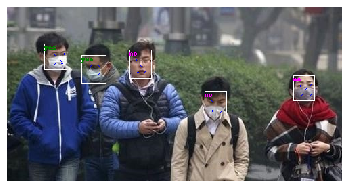

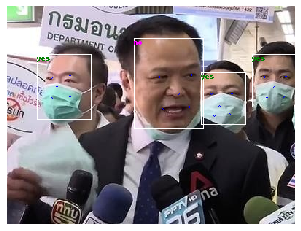

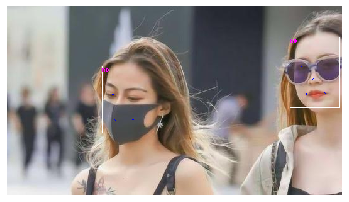

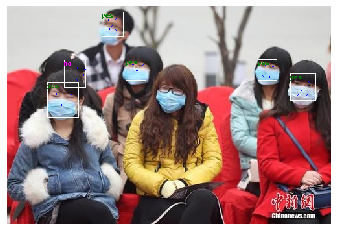

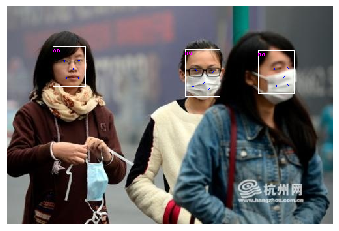

In [2]:
from torch_py.Utils import plot_image
from torch_py.MTCNN.detector import FaceDetector
from torch_py.MobileNetV1 import MobileNetV1
from torch_py.FaceRec import Recognition
from PIL import Image
import cv2
import numpy as np

# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 dnn.h5 模型，则 model_path = 'results/temp.pth'
model_path = 'results/temp.pth'
# ---------------------------------------------------------------------------


def predict(img):
    """
    加载模型和模型预测
    :param img: cv2.imread 图像
    :return: 预测的图片中的总人数、其中佩戴口罩的人数
    """
    # -------------------------- 实现模型预测部分的代码 ---------------------------
    # 将 cv2.imread 图像转化为 PIL.Image 图像，用来兼容测试输入的 cv2 读取的图像（勿删！！！）
    # cv2.imread 读取图像的类型是 numpy.ndarray
    # PIL.Image.open 读取图像的类型是 PIL.JpegImagePlugin.JpegImageFile
    if isinstance(img, np.ndarray):
        # 转化为 PIL.JpegImagePlugin.JpegImageFile 类型
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    recognize = Recognition(model_path)
    img, all_num, mask_num = recognize.mask_recognize(img)
    plot_image(img)
    # -------------------------------------------------------------------------
    return all_num, mask_num


all_num = 0
mask_num = 0
for i in range(5):
    # 输入图片路径和名称
    img = cv2.imread(f"test{i}.jpg")
    this_all_num, this_mask_num = predict(img)
    # 打印预测该张图片中总人数以及戴口罩的人数
    all_num += this_all_num
    mask_num += this_mask_num